# Final March Madness 2022 Prediction Model

## Loading in Data

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# MARCH_MADNESS_DATA is a composite of all of my previous data as well as all the data scraped from ESPN
df = pd.read_csv('MARCH_MADNESS_DATA.csv')
df.head()

,YEAR,ROUND,REGION,T1ID,T1SEED,T1SCORE,T1NAME,T1PTS,T1REB,T1AST,...,T2SOS,T2SOR,T2REC,T2HREC,T2AREC,SEEDDIFF,BPIDIFF,SOSDIFF,SORDIFF,WINNER
0,2008,1.0,1.0,153,1,113,North Carolina Tar Heels,88.7,44.2,16.7,...,246,182,0.559,0.5,0.533,-15,-169,-237,-181,0
1,2008,1.0,1.0,2633,2,72,Tennessee Volunteers,83.0,38.1,18.2,...,223,141,0.636,0.667,0.588,-13,-143,-204,-136,0
2,2008,1.0,1.0,97,3,79,Louisville Cardinals,71.9,37.8,14.8,...,235,82,0.735,0.688,0.786,-11,-122,-221,-70,0
3,2008,1.0,1.0,265,4,71,Washington State Cougars,67.1,29.2,13.7,...,129,90,0.647,0.786,0.455,-9,-68,-108,-77,0
4,2008,1.0,1.0,87,5,68,Notre Dame Fighting Irish,80.6,41.6,18.9,...,179,96,0.676,0.929,0.417,-7,-48,-127,-79,0


In [3]:
# Drop unneeded columns
df = df.drop(columns=['T1NAME','T2NAME','T1SCORE','T2SCORE','REGION','YEAR','ROUND',
                      'T1ID','T1HW','T1HL','T1AW','T1AL','T1HREC','T1AREC',
                      'T2ID','T2HW','T2HL','T2AW','T2AL','T2HREC','T2AREC',])

In [4]:
df = df.dropna()

## Building the Model

In [5]:
x = df.iloc[:,:-1]
y = df.WINNER

In [6]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=99)

In [7]:
# ### Random Forest
# from sklearn.model_selection import RandomizedSearchCV
# random_grid = {}
# random_grid['n_estimators'] = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# random_grid['max_features'] = ['auto', 'sqrt']
# random_grid['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 11)]
# random_grid['max_depth'].append(None)
# random_grid['min_samples_split'] = [2, 5, 10]
# random_grid['min_samples_leaf'] = [1, 2, 4]
# random_grid['bootstrap'] = [True, False]
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(
#     estimator=rf, 
#     param_distributions=random_grid, 
#     n_iter=500, cv=3, verbose=2,
#     n_jobs=-1)
# rf_random.fit(train_x, train_y)

In [8]:
# rf_random.best_params_

In [9]:
# {'n_estimators': 1600,
#  'min_samples_split': 5,
#  'min_samples_leaf': 4,
#  'max_features': 'auto',
#  'max_depth': 60,
#  'bootstrap': False}

In [10]:
# Train RF based on best parameters from randomized search
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=1500,
    min_samples_leaf=4,
    max_features='auto',
    max_depth=50,
    bootstrap=True)
rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=1500)

In [11]:
# Log loss was the metric used in the Kaggle competition
from sklearn.metrics import accuracy_score, log_loss

### Random Forest
rf_pred = rf.predict(test_x)
rf_acc = accuracy_score(test_y, rf_pred)
rf_predprob = rf.predict_proba(test_x)
print(f"{'Random Forest':<20} ==> {round(rf_acc * 100, 2)}")
print(f"{'Log Loss':<20} ==> {round(log_loss(test_y, rf_predprob), 3)}")

Random Forest        ==> 84.24
Log Loss             ==> 0.405


In [12]:
# Feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

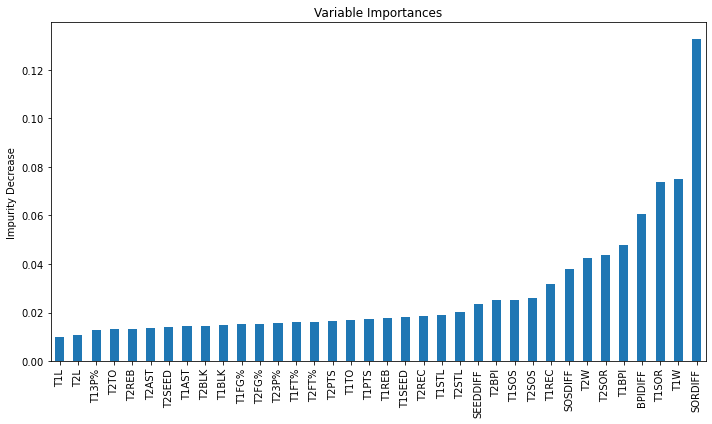

In [13]:
feature_names = list(df.columns[:-1])
forest_importances = pd.Series(importances, index=feature_names).sort_values()
fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Variable Importances")
ax.set_ylabel("Impurity Decrease")
fig.tight_layout()

## Updating ID's to match Kaggle Competition

In [14]:
spell = pd.read_csv('./data/MDataFiles_Stage1/MTeamSpellings.csv', encoding='cp1252')
ids = pd.read_csv('./data/id_name.csv')

### Convert from ESPN to Kaggle ids

In [15]:
new_ids = {}
for idx1, row1 in ids.iterrows():
    if idx1 % 100 == 0:
        print(f"Processing row {idx1}/{ids.shape[0]}...")
    team1name = row1['Team1'].lower().replace(' ', '')
    team2name = row1['Team2'].lower().replace(' ', '')
    team1id = row1['team1id']
    team2id = row1['team2id']
    if team1id not in new_ids:
        new_ids[team1id] = {'name':team1name, 'new_ids':[]}
    if team2id not in new_ids:
        new_ids[team2id] = {'name':team2name, 'new_ids':[]}
    for idx2, row2 in spell.iterrows():
        if row2['TeamNameSpelling'].lower().replace(' ', '') == team1name:
            if row2['TeamID'] not in new_ids[team1id]['new_ids']:
                new_ids[team1id]['new_ids'].append(row2['TeamID'])
        if row2['TeamNameSpelling'].lower().replace(' ', '') == team2name:
            if row2['TeamID'] not in new_ids[team2id]['new_ids']:
                new_ids[team2id]['new_ids'].append(row2['TeamID'])

Processing row 0/823...
Processing row 100/823...
Processing row 200/823...
Processing row 300/823...
Processing row 400/823...
Processing row 500/823...
Processing row 600/823...
Processing row 700/823...
Processing row 800/823...


In [16]:
# Ids that were incorrectly classified
print("Teams with incorrect ids:\n")
id_set = set(list(ids.team1id) + list(ids.team2id))
name_set = set(list(ids.Team1) + list(ids.Team2))
not_found = []
for name in name_set:
    found = False
    for id in id_set:
        if new_ids[id]['name'] == name.lower().replace(' ',''):
            found = True
    if not found:
        print(name)
        not_found.append(name)

Teams with incorrect ids:

Cleveland State
Utah State
UConn
Oregon State
Mount St. Mary's
Oklahoma State
UC Irvine
Morehead State
UC Santa Barbara
Michigan State
St. Bonaventure
Norfolk State
St Marys
Florida State
Ohio State
Wichita State
Lafayette
San Diego State
Utah


In [17]:
# Manually fix mislabeled ids
new_ids[254] = {'name':'utah', 'new_ids':[1428]}
new_ids[2608] = {'name': 'st marys', 'new_ids':[1388]}
new_ids[2603]['new_ids'] = [1386]
new_ids[2239]['new_ids'] = [1168]
new_ids[2309]['new_ids'] = [1245]
new_ids[251]['new_ids'] = [1400]
new_ids[2390]['new_ids'] = [1274]
new_ids[2400]['new_ids'] = [1290]
new_ids[2449]['new_ids'] = [1295]
new_ids[2463]['new_ids'] = [1169]
new_ids[2193]['new_ids'] = [1190]
new_ids[2617]['new_ids'] = [1372]
new_ids[2029]['new_ids'] = [1115]
new_ids[112358]['new_ids'] = [1254]
new_ids[2612]['new_ids'] = [1389]
new_ids[2599]['new_ids'] = [1385]
new_ids[2571]['new_ids'] = [1355]
new_ids[2466]['new_ids'] = [1322]
new_ids[270]['new_ids'] = [1454]
new_ids[2934]['new_ids'] = [1167]
new_ids[2739]['new_ids'] = [1453]
new_ids[2393]['new_ids'] = [1292]
new_ids[2031]['new_ids'] = [1114]

In [18]:
# Ids from 2022 teams
ids22 = pd.read_csv('./predictions/2022Teams.csv', header=None)
ids22.columns = ['Name']

In [19]:
# Convert 2022 team ids to Kaggle ids
team_ids = {}
for idx1, row1 in ids22.iterrows():
    if idx1 % 10 == 0:
        print(f"Processing team {idx1}/{ids22.shape[0]}...")
    teamName = row1['Name']
    teamName_ = teamName.lower().replace(' ', '')
    for idx2, row2 in spell.iterrows():
        if row2['TeamNameSpelling'].lower().replace(' ', '') == teamName_:
                team_ids[teamName] = row2['TeamID']
                ids22.loc[idx1,'ID'] = row2['TeamID']

Processing team 0/68...
Processing team 10/68...
Processing team 20/68...
Processing team 30/68...
Processing team 40/68...
Processing team 50/68...
Processing team 60/68...


In [20]:
# Manually update teams with no historical tournament data
ids22.loc[1,'ID'] = 1394
ids22.loc[13,'ID'] = 1308
ids22.loc[27,'ID'] = 1388
ids22.loc[37,'ID'] = 1389
ids22.loc[52,'ID'] = 1174
ids22.loc[54,'ID'] = 1361
ids22.loc[59,'ID'] = 1355

In [21]:
# Create inverse dictionary
new_ids_inv = {}
for id in new_ids:
    new_ids_inv[new_ids[id]['new_ids'][0]] = id

In [22]:
# Update inverse dictionary ids
new_ids_inv[1394] = 357
new_ids_inv[1136] = 2803
new_ids_inv[1286] = 147
new_ids_inv[1388] = 2608
new_ids_inv[1362] = 2539
new_ids_inv[1255] = 2344

## Preparing 2022 Data

In [23]:
games_2022 = pd.read_csv('./data/MDataFiles_Stage2/MSampleSubmissionStage2.csv')
seeds_2022 = pd.read_csv('./data/MDataFiles_Stage2/MNCAATourneySeeds.csv')

In [24]:
# !!! MongoDB hosted locally
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.ncaa
teams = db.teams2

The MODEL_INPUT_2022.csv file can be found in the ```model_input/``` directory

In [25]:
# with open('./model_input/MODEL_INPUT_2022.csv', 'w') as f:
#     f.write('T1ID,T1SEED,T1SCORE,T1NAME,T1PTS,T1REB,T1AST,T1STL,T1BLK,T1TO,T1FG%,T1FT%,T13P%,T1W,T1L,T1BPI,T1SOS,T1SOR,T1REC,')
#     f.write('T2ID,T2SEED,T2SCORE,T2NAME,T2PTS,T2REB,T2AST,T2STL,T2BLK,T2TO,T2FG%,T2FT%,T23P%,T2W,T2L,T2BPI,T2SOS,T2SOR,T2REC,')
#     f.write('SEEDDIFF,BPIDIFF,SOSDIFF,SORDIFF\n')
#     for idx, row in games_2022.iterrows():
#         if idx % 100 == 0:
#             print(idx)
#         year = row['ID'][:4]
#         t1id_ = row['ID'][5:9]
#         t2id_ = row['ID'][10:]
#         try:
#             team1 = teams.find_one({'year': year, 'id_num': str(new_ids_inv[int(t1id_)])})
#         except KeyError:
#             team1 = teams.find_one({'ID': '99999999'})
#         try:
#             team2 = teams.find_one({'year': year, 'id_num': str(new_ids_inv[int(t2id_)])})
#         except KeyError:
#             team2 = teams.find_one({'ID': '99999999'})

#         ### TEAM 1 INFO ###
#         t1id = team1['id_num']
#         t1seed = seeds_2022[(seeds_2022.Season == 2022) & (seeds_2022.TeamID == int(t1id_))].iloc[0,1][1:3]
#         t1score = 0
#         t1name = team1['name']
#         t1PTS = team1['stats']['PTS']
#         t1REB = team1['stats']['REB']
#         t1AST = team1['stats']['AST']
#         t1STL = team1['stats']['STL']
#         t1BLK = team1['stats']['BLK']
#         t1TOV = team1['stats']['TO']
#         t1FG = team1['stats']['FG%']
#         t1FT = team1['stats']['FT%']
#         t13P = team1['stats']['3P%']
#         t1w = team1['record']['record'].split('-')[0]
#         t1l = team1['record']['record'].split('-')[1]
#         if int(t1w) > 0 and int(t1l) > 0:
#             t1rec = round(int(t1w) / (int(t1w) + int(t1l)),3)
#         else:
#             t1rec = 0
#         t1bpi = team1['ranking']['bpi']
#         t1sos = team1['ranking']['sos']
#         t1sor = team1['ranking']['sor']
#         f.write(f'{t1id},{t1seed},{t1score},{t1name},{t1PTS},{t1REB},{t1AST},{t1STL},{t1BLK},{t1TOV},{t1FG},{t1FT},{t13P},{t1w},{t1l},{t1bpi},{t1sos},{t1sor},{t1rec},')

#         ### TEAM 2 INFO ###
#         t2id = team2['id_num']
#         t2seed = seeds_2022[(seeds_2022.Season == 2022) & (seeds_2022.TeamID == int(t2id_))].iloc[0,1][1:3]
#         t2score = 0
#         t2name = team2['name']
#         t2PTS = team2['stats']['PTS']
#         t2REB = team2['stats']['REB']
#         t2AST = team2['stats']['AST']
#         t2STL = team2['stats']['STL']
#         t2BLK = team2['stats']['BLK']
#         t2TOV = team2['stats']['TO']
#         t2FG = team2['stats']['FG%']
#         t2FT = team2['stats']['FT%']
#         t23P = team2['stats']['3P%']
#         t2w = team2['record']['record'].split('-')[0]
#         t2l = team2['record']['record'].split('-')[1]
#         if int(t2w) > 0 and int(t2l) > 0:
#             t2rec = round(int(t2w) / (int(t2w) + int(t2l)),3)
#         else:
#             t2rec = 0
#         t2bpi = team2['ranking']['bpi']
#         t2sos = team2['ranking']['sos']
#         t2sor = team2['ranking']['sor']
#         f.write(f'{t2id},{t2seed},{t2score},{t2name},{t2PTS},{t2REB},{t2AST},{t2STL},{t2BLK},{t2TOV},{t2FG},{t2FT},{t23P},{t2w},{t2l},{t2bpi},{t2sos},{t2sor},{t2rec},')

#         winner = 0 if int(t1score) > int(t2score) else 1
#         seed_diff = int(t1seed) - int(t2seed)
#         bpi_diff = int(t1bpi) - int(t2bpi)
#         sos_diff = int(t1sos) - int(t2sos)
#         sor_diff = int(t1sor) - int(t2sor)
#         f.write(f'{seed_diff},{bpi_diff},{sos_diff},{sor_diff}\n')

In [26]:
# 2022 Dataset
x_FINAL = pd.read_csv('./model_input/MODEL_INPUT_2022.csv')
x_FINAL = x_FINAL.drop(columns=['T1NAME','T2NAME','T1SCORE','T2SCORE',
                      'T1ID','T2ID',])

## Overall Predictions

In [27]:
x = df.iloc[:,:-1]
y = df.WINNER

all_preds = None
for i in range(10):
    print(f"Processing prediction set {i+1}")
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
    rf = RandomForestClassifier(
        n_estimators=1500,
    #     min_samples_split=5, 
        min_samples_leaf=4,
        max_features='auto',
        max_depth=50,
        bootstrap=True)
    rf.fit(train_x, train_y)
    final_preds_2022 = rf.predict_proba(x_FINAL)
    if all_preds is None:
        all_preds = final_preds_2022
    else:
        all_preds += final_preds_2022
all_preds /= 10

Processing prediction set 1
Processing prediction set 2
Processing prediction set 3
Processing prediction set 4
Processing prediction set 5
Processing prediction set 6
Processing prediction set 7
Processing prediction set 8
Processing prediction set 9
Processing prediction set 10


In [28]:
games_2022_pred = games_2022.drop(columns=['Pred'])
for idx, row in games_2022_pred.iterrows():
    games_2022_pred.loc[idx, 'Pred'] = all_preds[idx][0]

In [29]:
# Export submission to csv
games_2022_pred.to_csv('./sumissions/SUBMISSION_STAGE2.csv', index=False)